In [1]:
!pip install pytorch-crf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchcrf import CRF
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [4]:
class MixedTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        boundary_idx = int(self.labels[idx])
        words = text.split()
        if len(words) > self.max_len - 2:
            if boundary_idx > self.max_len - 2:
                words = words[-(self.max_len - 2):]
                boundary_idx = 0
            else:
                words = words[:self.max_len - 2]
        word_labels = [0 if i <= boundary_idx else 1 for i in range(len(words))]
        truncated_text = " ".join(words)
        encoding = self.tokenizer(
            truncated_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_special_tokens_mask=True
        )
        special_tokens_mask = encoding['special_tokens_mask'][0]
        token_labels = []
        current_word_idx = 0

        for is_special in special_tokens_mask:
            if is_special:
                token_labels.append(-100)
            else:
                if current_word_idx < len(word_labels):
                    token_labels.append(word_labels[current_word_idx])
                    current_word_idx += 1
                else:
                    token_labels.append(-100)
        token_labels = token_labels[:self.max_len]
        if len(token_labels) < self.max_len:
            token_labels.extend([-100] * (self.max_len - len(token_labels)))
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(token_labels)
        }

In [5]:
import torch
import torch.nn as nn
import torchcrf
from transformers import AutoModel

class TransformerBiLSTMCRF(nn.Module):
    def __init__(self, transformer_model, hidden_dim, num_labels):
        super(TransformerBiLSTMCRF, self).__init__()
        self.num_labels = num_labels
        self.transformer = AutoModel.from_pretrained(transformer_model)
        self.lstm = nn.LSTM(input_size=self.transformer.config.hidden_size, hidden_size=hidden_dim, num_layers=3, bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.activation = nn.ReLU()
        self.crf = torchcrf.CRF(num_labels, batch_first=True)
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, input_ids, attention_mask, labels=None):
        transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = transformer_outputs.last_hidden_state
        lstm_out, _ = self.lstm(sequence_output)
        emissions = self.fc(self.activation(lstm_out))
        if labels is not None:
          mask = attention_mask.bool()
          crf_labels = labels.clone()
          crf_labels[crf_labels == -100] = 0
          log_likelihood = self.crf(emissions, crf_labels, mask=mask, reduction='mean')
          return -log_likelihood
        else:
            predictions = self.crf.decode(emissions, mask=attention_mask.bool())
            return predictions


In [6]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(predictions, labels):
    predictions = np.array(predictions)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted", zero_division=0)
    f1 = f1_score(labels, predictions, average="weighted", zero_division=0)
    mcc = matthews_corrcoef(labels, predictions)
    return accuracy, precision, recall, f1, mcc

def train_model(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels)  # Compute loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            predictions = model(input_ids, attention_mask)
            for pred_seq, label_seq, mask_seq in zip(predictions, labels, attention_mask):
                pred_seq = torch.tensor(pred_seq, device=device)
                if len(pred_seq) < mask_seq.size(0):
                    padding = torch.zeros(mask_seq.size(0) - len(pred_seq), device=device)
                    pred_seq = torch.cat([pred_seq, padding])
                mask_seq = mask_seq.to(device)
                label_seq = label_seq.to(device)
                valid_indices = (mask_seq == 1) & (label_seq != -100)
                valid_pred = pred_seq[valid_indices].cpu().numpy()
                valid_label = label_seq[valid_indices].cpu().numpy()
                all_predictions.extend(valid_pred)
                all_labels.extend(valid_label)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    mae = np.mean(np.abs(all_predictions - all_labels))
    std_dev = np.std(all_predictions - all_labels)

    return accuracy, precision, recall, f1, mcc, mae, std_dev

In [11]:
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

MODEL_NAME = 'microsoft/deberta-v3-base'
HIDDEN_DIM = 256

def setup_training(train_texts, train_labels, dev_texts, dev_labels, model_name=MODEL_NAME, batch_size=8, max_len=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = MixedTextDataset(train_texts, train_labels, tokenizer, max_len)
    dev_dataset = MixedTextDataset(dev_texts, dev_labels, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerBiLSTMCRF(model_name, hidden_dim=HIDDEN_DIM, num_labels=2)
    model.to(device)

    optimizer_grouped_parameters = [
        {"params": model.transformer.embeddings.parameters(), "lr": 1e-6},
        {"params": model.transformer.encoder.layer[:6].parameters(), "lr": 5e-6},
        {"params": model.transformer.encoder.layer[6:].parameters(), "lr": 1e-5},
        {"params": model.lstm.parameters(), "lr": 1e-4},
        {"params": model.fc.parameters(), "lr": 1e-4},
        {"params": model.crf.parameters(), "lr": 1e-4},
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-6, weight_decay=0.01)

    num_training_steps = len(train_loader) * 3
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

    return model, train_loader, dev_loader, optimizer, scheduler, device


In [12]:
train_df = pd.read_csv('/content/drive/MyDrive/SCI AIGC/sentence_level_train_hc3.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/SCI AIGC/sentence_level_dev_hc3.csv')

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
dev_texts = dev_df["text"].tolist()
dev_labels = dev_df["label"].tolist()

model, train_loader, dev_loader, optimizer, scheduler, device = setup_training(train_texts, train_labels, dev_texts, dev_labels, MODEL_NAME)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset = MixedTextDataset([train_texts[0]], [train_labels[0]], tokenizer, max_len=512)
sample = dataset[0]
print(f"Input sequence length: {len(sample['input_ids'])}")
print(f"Label sequence length: {len(sample['labels'])}")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Input sequence length: 512
Label sequence length: 512


In [14]:
tokenizer

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [15]:
import torch

def extract_lstm_features(model, sentences, tokenizer, max_len=512, device='cpu'):
    model.eval()
    features = []

    for sentence in sentences:
        encoding = tokenizer(
            sentence,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            transformer_outputs = model.transformer(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = transformer_outputs.last_hidden_state
            lstm_output, _ = model.lstm(sequence_output)
            lstm_features = lstm_output.mean(dim=1).cpu().numpy()
            features.append(lstm_features)

    return np.vstack(features)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerBiLSTMCRF(
  (transformer): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [17]:
df = pd.read_csv('/content/drive/MyDrive/SCI AIGC/all_hc3_processed.csv')
df

,question,human_answers,chatgpt_answers,human_answers_cleaned,chatgpt_answers_cleaned,human_answers_truncated,chatgpt_answers_truncated,text,label
0,"Why is every book I hear about a "" NY Times # ...","['Basically there are many categories of "" Bes...",['There are many different best seller lists t...,basically there are many categories of best se...,there are many different best seller lists tha...,basically there are many categories of best se...,there are many different best seller lists tha...,basically there are many categories of best se...,107
1,"If salt is so bad for cars , why do we use it ...",['salt is good for not dying in car crashes an...,"[""Salt is used on roads to help melt ice and s...",salt is good for not dying in car crashes and ...,salt is used on roads to help melt ice and sno...,salt is good for not dying in car crashes and ...,salt is used on roads to help melt ice and sno...,salt is good for not dying in car crashes and ...,194
2,Why do we still have SD TV channels when HD lo...,"[""The way it works is that old TV stations got...","[""There are a few reasons why we still have SD...",the way it works is that old tv stations got a...,there are a few reasons why we still have sd s...,the way it works is that old tv stations got a...,there are a few reasons why we still have sd s...,the way it works is that old tv stations got a...,222
3,Why has nobody assassinated Kim Jong - un He i...,"[""You ca n't just go around assassinating the ...",['It is generally not acceptable or ethical to...,you ca nt just go around assassinating the lea...,it is generally not acceptable or ethical to a...,you ca nt just go around assassinating the lea...,it is generally not acceptable or ethical to a...,you ca nt just go around assassinating the lea...,90
4,How was airplane technology able to advance so...,['Wanting to kill the shit out of Germans driv...,['After the Wright Brothers made the first pow...,wanting to kill the shit out of germans drives...,after the wright brothers made the first power...,wanting to kill the shit out of germans drives...,after the wright brothers made the first power...,wanting to kill the shit out of germans drives...,124
...,...,...,...,...,...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,['Hello!Welcome and thank you for asking on HC...,"[""It's not uncommon for blood pressure to fluc...",hellowelcome and thank you for asking on hcmre...,its not uncommon for blood pressure to fluctua...,hellowelcome and thank you for asking on hcmre...,its not uncommon for blood pressure to fluctua...,hellowelcome and thank you for asking on hcmre...,70
24318,What could cause a painless lump in the right ...,"['Hi, * As per my surgical experience, the iss...",['There are several possible causes of a painl...,hi as per my surgical experience the issue sou...,there are several possible causes of a painles...,hi as per my surgical experience the issue sou...,there are several possible causes of a painles...,hi as per my surgical experience the issue sou...,36
24319,Can Acutret be given to a child for treatment ...,['Although it is difficult to comment whether ...,"[""It is not appropriate for me to recommend a ...",although it is difficult to comment whether ac...,it is not appropriate for me to recommend a sp...,although it is difficult to comment whether ac...,it is not appropriate for me to recommend a sp...,although it is difficult to comment whether ac...,42
24320,Are BP of 119/65 and pulse of 35 causes for co...,['Welcome and thank you for asking on HCM! I h...,['It is not uncommon for people with rheumatoi...,welcome and thank you for asking on hcm i have...,it is not uncommon for people with rheumatoid ...,welcome and thank you for asking on hcm i have...,it is not uncommon for people with rheumatoid ...,welcome and thank you for asking on hcm i have...,23


In [18]:
df.columns

Index(['question', 'human_answers', 'chatgpt_answers', 'human_answers_cleaned',
       'chatgpt_answers_cleaned', 'human_answers_truncated',
       'chatgpt_answers_truncated', 'text', 'label'],
      dtype='object')

In [20]:
human_features = extract_lstm_features(model, df["human_answers_truncated"], tokenizer, device=device)

In [21]:
import torch

def extract_lstm_features(model, sentences, tokenizer, max_len=512, device='cpu'):
    model.eval()
    features = []
    sentences = sentences.apply(lambda x: str(x) if pd.notna(x) else "")
    for sentence in sentences:
        encoding = tokenizer(
            sentence,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            transformer_outputs = model.transformer(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = transformer_outputs.last_hidden_state
            lstm_output, _ = model.lstm(sequence_output)
            lstm_features = lstm_output.mean(dim=1).cpu().numpy()
            features.append(lstm_features)

    return np.vstack(features)


In [22]:
machine_features = extract_lstm_features(model, df["chatgpt_answers_truncated"], tokenizer, device=device)

In [23]:
features = np.vstack((human_features, machine_features))
labels = np.array(["Human"] * len(human_features) + ["Machine"] * len(machine_features))

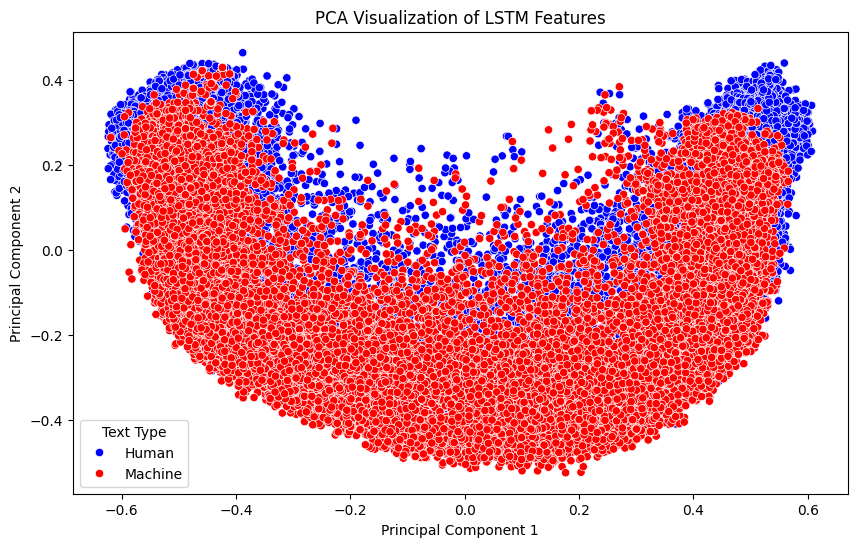

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from umap import UMAP
from scipy.stats import ttest_ind, f_oneway

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("PCA Visualization of LSTM Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Text Type")
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind, f_oneway

def plot_3d(features, labels, title, palette):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    colors = sns.color_palette(palette, n_colors=len(set(labels)))
    for label, color in zip(np.unique(labels), colors):
        mask = labels == label
        ax.scatter(features[mask, 0], features[mask, 1], features[mask, 2], label=label, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    ax.legend(title="Text Type")
    plt.show()



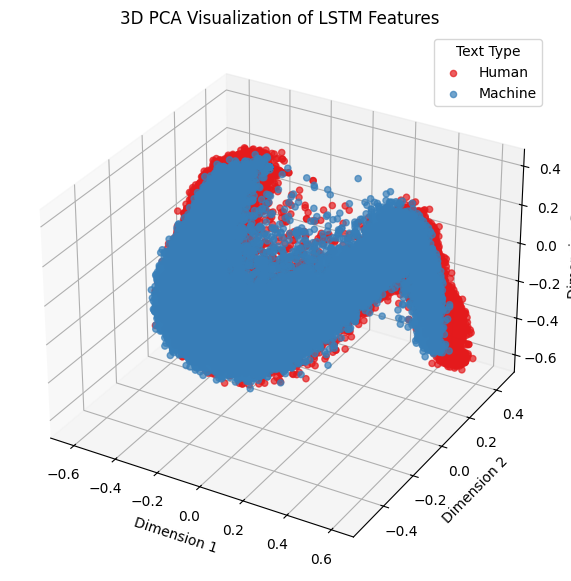

In [26]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)
plot_3d(pca_features, labels, "3D PCA Visualization of LSTM Features", palette="Set1")

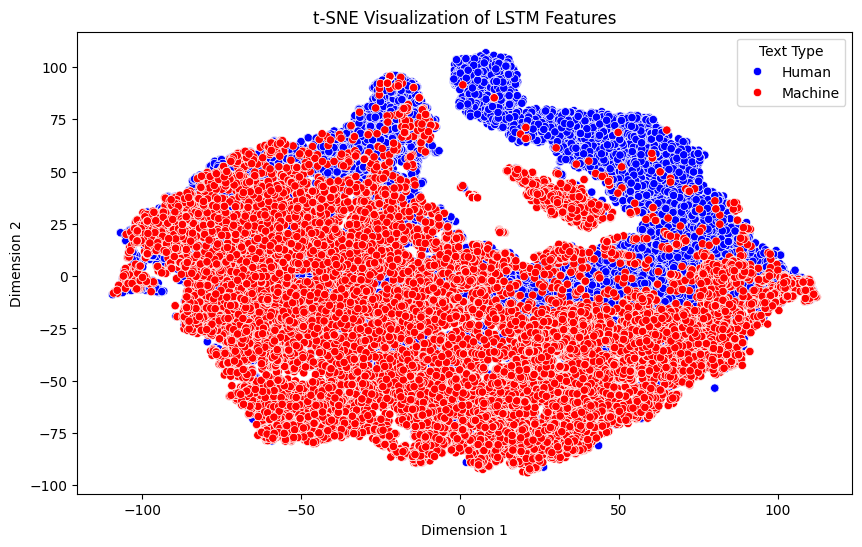

In [27]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("t-SNE Visualization of LSTM Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Text Type")
plt.show()


In [39]:
import os
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"

In [41]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [42]:
# !pip install umap-learn

In [43]:
from umap import UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


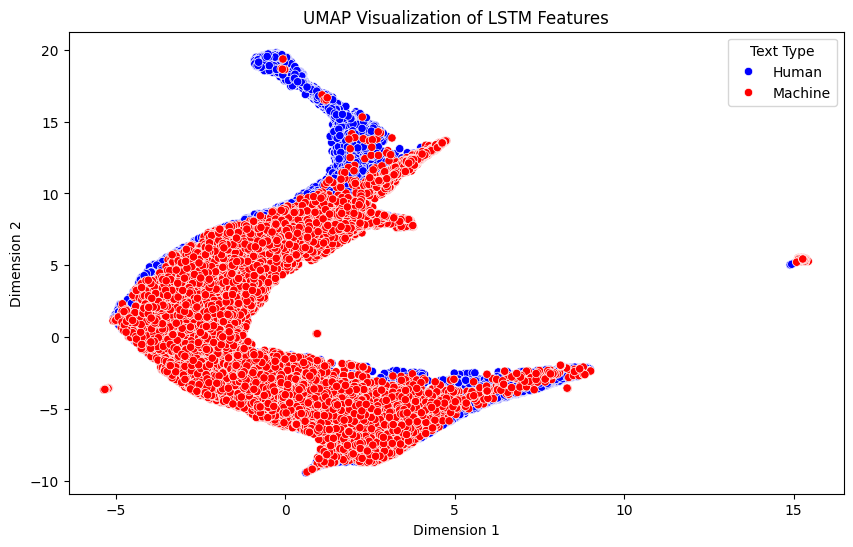

In [44]:
umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("UMAP Visualization of LSTM Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Text Type")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


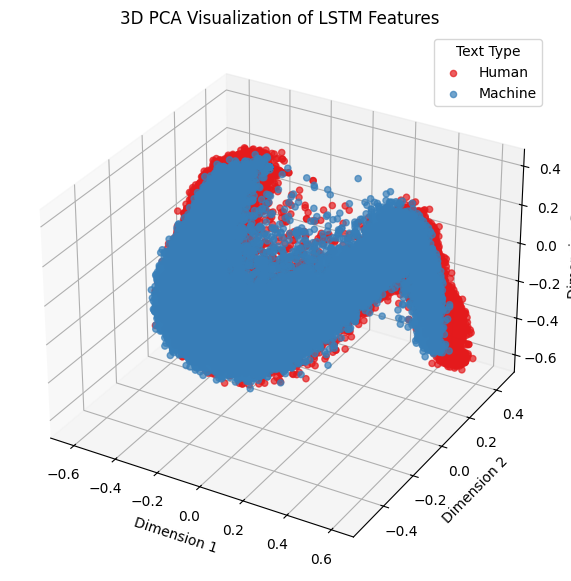

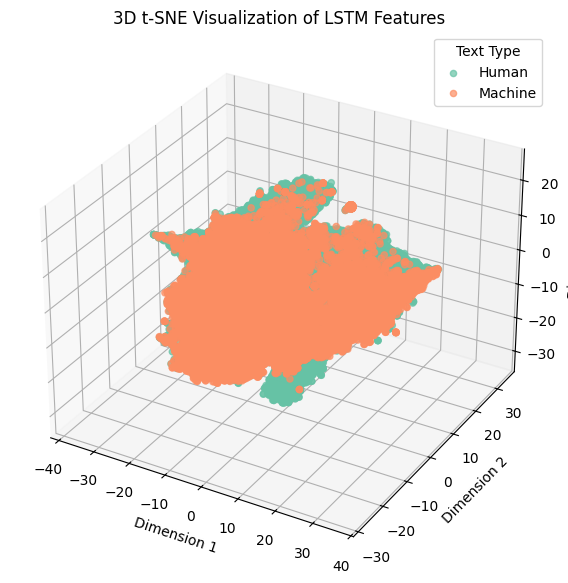

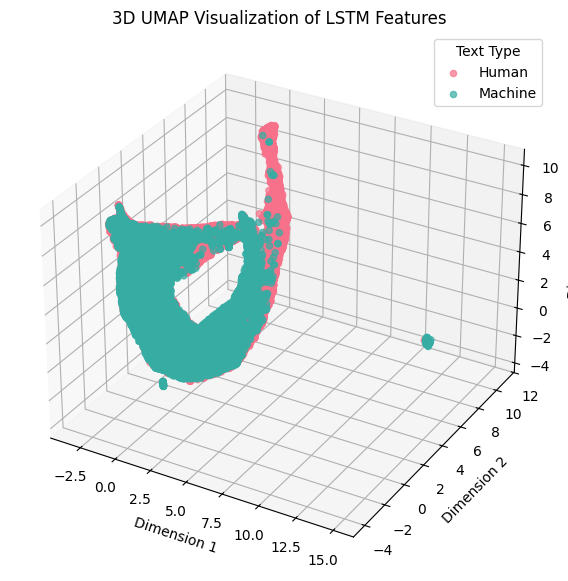

T-Test: t-statistic=30.136, p-value=1.665e-199
ANOVA: F-statistic=908.159, p-value=1.667e-199

Top 5 Dimensions with the Largest T-Statistic:
Dimension 128: t-stat=-131.309, p-value=0.000e+00
Dimension 369: t-stat=129.826, p-value=0.000e+00
Dimension 294: t-stat=-114.174, p-value=0.000e+00
Dimension 438: t-stat=-109.771, p-value=0.000e+00
Dimension 462: t-stat=109.755, p-value=0.000e+00


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind, f_oneway

features = np.vstack((human_features, machine_features))
labels = np.array(["Human"] * len(human_features) + ["Machine"] * len(machine_features))

pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)

tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(features)

umap = UMAP(n_components=3, random_state=42)
umap_features = umap.fit_transform(features)

def plot_3d(features, labels, title, palette):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    colors = sns.color_palette(palette, n_colors=len(set(labels)))
    for label, color in zip(np.unique(labels), colors):
        mask = labels == label
        ax.scatter(features[mask, 0], features[mask, 1], features[mask, 2], label=label, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    ax.legend(title="Text Type")
    plt.show()

plot_3d(pca_features, labels, "3D PCA Visualization of LSTM Features", palette="Set1")

plot_3d(tsne_features, labels, "3D t-SNE Visualization of LSTM Features", palette="Set2")

plot_3d(umap_features, labels, "3D UMAP Visualization of LSTM Features", palette="husl")

human_flat = human_features.flatten()
machine_flat = machine_features.flatten()

t_stat, t_pvalue = ttest_ind(human_flat, machine_flat)
print(f"T-Test: t-statistic={t_stat:.3f}, p-value={t_pvalue:.3e}")

f_stat, f_pvalue = f_oneway(human_flat, machine_flat)
print(f"ANOVA: F-statistic={f_stat:.3f}, p-value={f_pvalue:.3e}")

dimension_stats = []
for dim in range(features.shape[1]):
    t_stat_dim, t_pvalue_dim = ttest_ind(human_features[:, dim], machine_features[:, dim])
    dimension_stats.append((dim, t_stat_dim, t_pvalue_dim))

top_differing_dimensions = sorted(dimension_stats, key=lambda x: abs(x[1]), reverse=True)[:5]
print("\nTop 5 Dimensions with the Largest T-Statistic:")
for dim, t_stat_dim, pvalue_dim in top_differing_dimensions:
    print(f"Dimension {dim}: t-stat={t_stat_dim:.3f}, p-value={pvalue_dim:.3e}")


In [47]:
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [50]:
df.columns

Index(['question', 'human_answers', 'chatgpt_answers', 'human_answers_cleaned',
       'chatgpt_answers_cleaned', 'human_answers_truncated',
       'chatgpt_answers_truncated', 'text', 'label'],
      dtype='object')

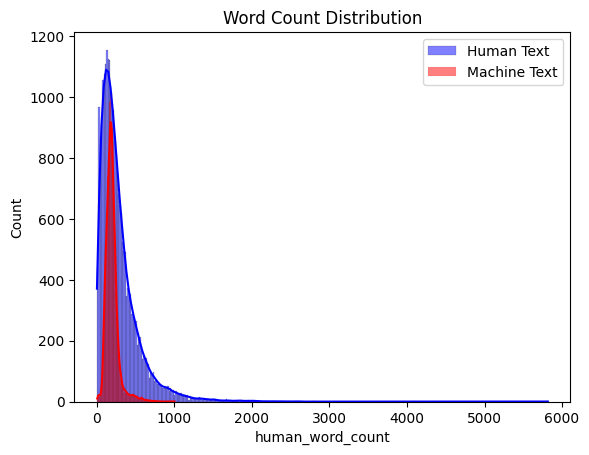

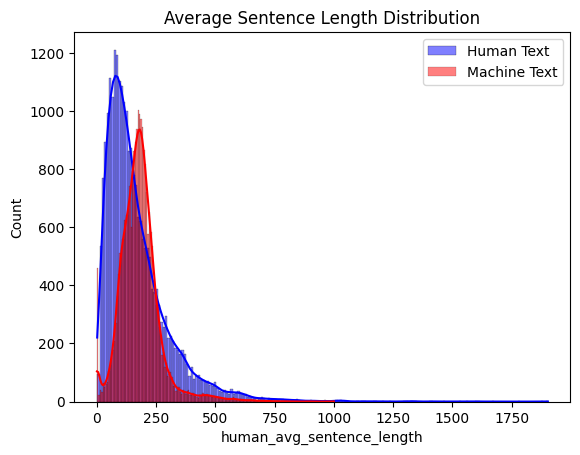

In [53]:
import pandas as pd
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

nlp = spacy.load("en_core_web_sm")

def lexical_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)
    if word_count == 0:
        return None, sentence_count, None, None
    avg_word_length = sum(len(word) for word in words) / word_count
    unique_words = set(words)
    ttr = len(unique_words) / word_count
    return word_count, sentence_count, avg_word_length, ttr

df['chatgpt_answers_cleaned'] = df['chatgpt_answers_cleaned'].fillna('')
df['human_lexical'] = df['human_answers_cleaned'].apply(lexical_features)
df['machine_lexical'] = df['chatgpt_answers_cleaned'].apply(lexical_features)
df = df.dropna(subset=['human_lexical', 'machine_lexical'])
df[['human_word_count', 'human_sentence_count', 'human_avg_word_length', 'human_ttr']] = pd.DataFrame(df['human_lexical'].to_list(), index=df.index)
df[['machine_word_count', 'machine_sentence_count', 'machine_avg_word_length', 'machine_ttr']] = pd.DataFrame(df['machine_lexical'].to_list(), index=df.index)

sns.histplot(df['human_word_count'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_word_count'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.title('Word Count Distribution')
plt.show()

def syntactic_features(text):
    doc = nlp(text)
    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

    pos_tags = pos_tag(word_tokenize(text))
    pos_counts = Counter(tag for word, tag in pos_tags)
    return avg_sentence_length, pos_counts

df['human_syntactic'] = df['human_answers_cleaned'].apply(syntactic_features)
df['machine_syntactic'] = df['chatgpt_answers_cleaned'].apply(syntactic_features)

df[['human_avg_sentence_length', 'human_pos_counts']] = pd.DataFrame(df['human_syntactic'].to_list(), index=df.index)
df[['machine_avg_sentence_length', 'machine_pos_counts']] = pd.DataFrame(df['machine_syntactic'].to_list(), index=df.index)

sns.histplot(df['human_avg_sentence_length'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_avg_sentence_length'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.title('Average Sentence Length Distribution')
plt.show()


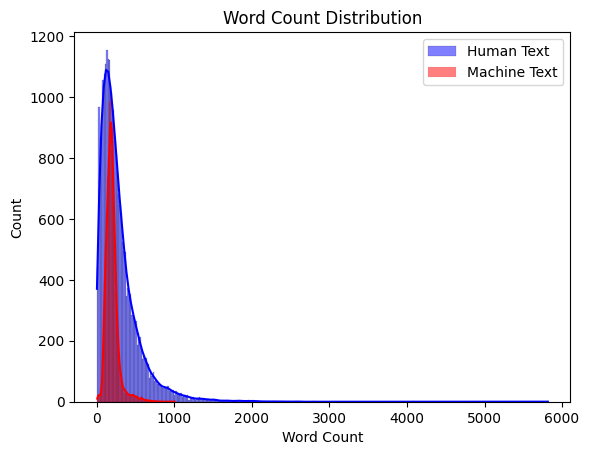

In [54]:
sns.histplot(df['human_word_count'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_word_count'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Word Count')
plt.title('Word Count Distribution')
plt.show()

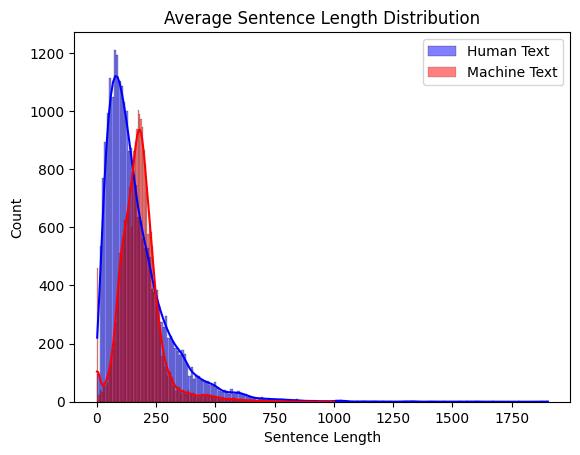

In [55]:
sns.histplot(df['human_avg_sentence_length'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_avg_sentence_length'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Sentence Length')
plt.title('Average Sentence Length Distribution')
plt.show()

In [ ]:
vectorizer = CountVectorizer(stop_words='english')

def semantic_features(human_text, machine_text):
    vectors = vectorizer.fit_transform([human_text, machine_text])
    similarity = cosine_similarity(vectors[0:1], vectors[1:2])
    return similarity[0][0]

df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_answers_cleaned'], row['chatgpt_answers_cleaned']), axis=1)
sns.histplot(df['semantic_similarity'], kde=True)
plt.title('Semantic Similarity Distribution')
plt.show()


In [60]:
vectorizer = CountVectorizer(stop_words='english')

def semantic_features(human_text, machine_text):
    if not human_text or not machine_text or \
       all(word in vectorizer.get_stop_words() for word in human_text.split()) or \
       all(word in vectorizer.get_stop_words() for word in machine_text.split()):
        return 0.0
    else:
        vectors = vectorizer.fit_transform([human_text, machine_text])
        similarity = cosine_similarity(vectors[0:1], vectors[1:2])
        return similarity[0][0]

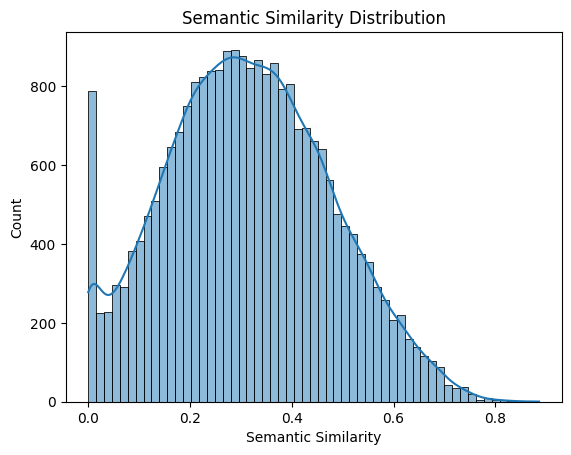

In [62]:
df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_answers_cleaned'], row['chatgpt_answers_cleaned']), axis=1)
sns.histplot(df['semantic_similarity'], kde=True)
plt.xlabel('Semantic Similarity')
plt.title('Semantic Similarity Distribution')
plt.show()

In [63]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

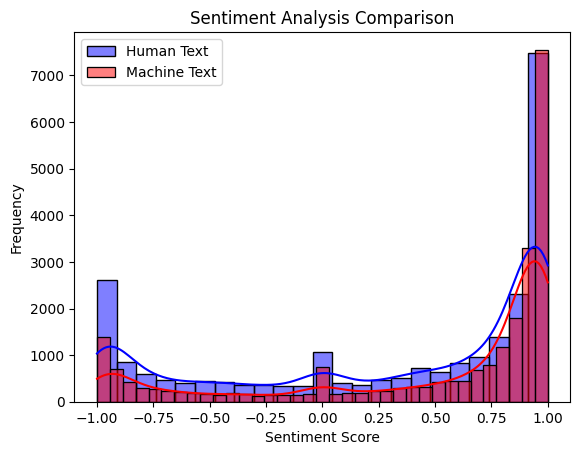

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df['human_sentiment'] = df['human_answers_cleaned'].apply(lambda text: sia.polarity_scores(text)['compound'])
df['machine_sentiment'] = df['chatgpt_answers_cleaned'].apply(lambda text: sia.polarity_scores(text)['compound'])

sns.histplot(df['human_sentiment'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_sentiment'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Comparison')
plt.show()


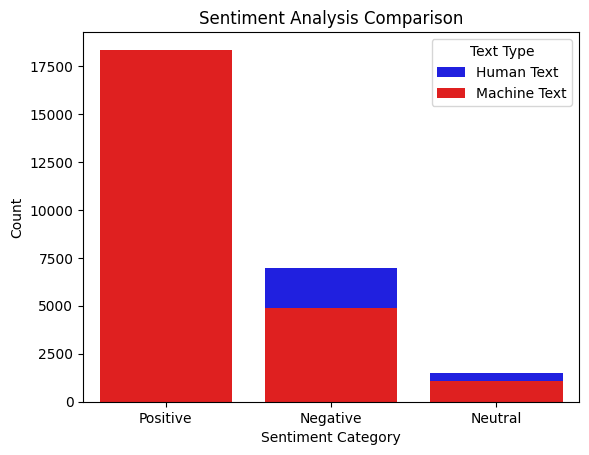

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def sentiment_category(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['human_sentiment_category'] = df['human_answers_cleaned'].apply(lambda text: sentiment_category(sia.polarity_scores(text)['compound']))
df['machine_sentiment_category'] = df['chatgpt_answers_cleaned'].apply(lambda text: sentiment_category(sia.polarity_scores(text)['compound']))

sns.countplot(x='human_sentiment_category', data=df, color='blue', label='Human Text')
sns.countplot(x='machine_sentiment_category', data=df, color='red', label='Machine Text')

plt.legend(title='Text Type')
plt.title('Sentiment Analysis Comparison')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


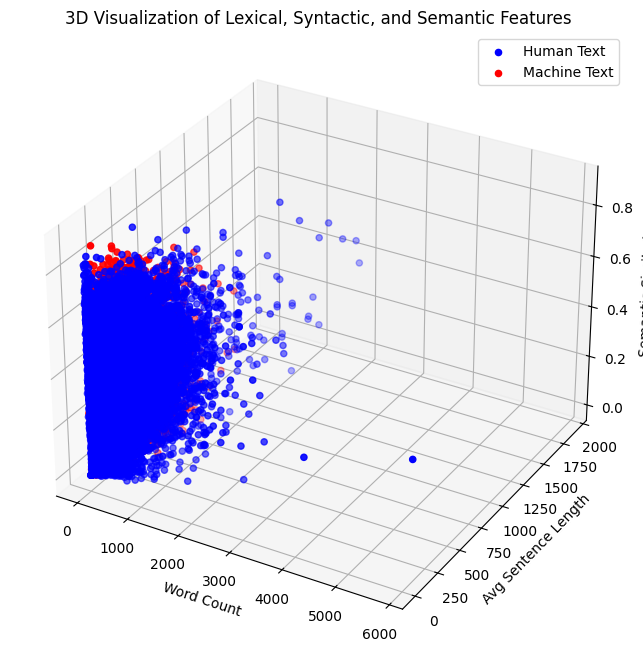

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_answers_cleaned'], row['chatgpt_answers_cleaned']), axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['human_word_count'], df['human_avg_sentence_length'], df['semantic_similarity'], color='blue', label='Human Text')

ax.scatter(df['machine_word_count'], df['machine_avg_sentence_length'], df['semantic_similarity'], color='red', label='Machine Text')

ax.set_xlabel('Word Count')
ax.set_ylabel('Avg Sentence Length')
ax.set_zlabel('Semantic Similarity')
ax.set_title('3D Visualization of Lexical, Syntactic, and Semantic Features')
ax.legend()

plt.show()


In [56]:
df

,question,human_answers,chatgpt_answers,human_answers_cleaned,chatgpt_answers_cleaned,human_answers_truncated,chatgpt_answers_truncated,text,label,human_lexical,...,machine_word_count,machine_sentence_count,machine_avg_word_length,machine_ttr,human_syntactic,machine_syntactic,human_avg_sentence_length,human_pos_counts,machine_avg_sentence_length,machine_pos_counts
0,"Why is every book I hear about a "" NY Times # ...","['Basically there are many categories of "" Bes...",['There are many different best seller lists t...,basically there are many categories of best se...,there are many different best seller lists tha...,basically there are many categories of best se...,there are many different best seller lists tha...,basically there are many categories of best se...,107,"(216, 1, 4.152777777777778, 0.5231481481481481)",...,207.0,1,4.289855,0.429952,"(216.0, {'RB': 22, 'EX': 1, 'VBP': 8, 'JJ': 15...","(207.0, {'EX': 2, 'VBP': 5, 'JJ': 24, 'JJS': 8...",216.0,"{'RB': 22, 'EX': 1, 'VBP': 8, 'JJ': 15, 'NNS':...",207.0,"{'EX': 2, 'VBP': 5, 'JJ': 24, 'JJS': 8, 'NN': ..."
1,"If salt is so bad for cars , why do we use it ...",['salt is good for not dying in car crashes an...,"[""Salt is used on roads to help melt ice and s...",salt is good for not dying in car crashes and ...,salt is used on roads to help melt ice and sno...,salt is good for not dying in car crashes and ...,salt is used on roads to help melt ice and sno...,salt is good for not dying in car crashes and ...,194,"(366, 1, 4.377049180327869, 0.5245901639344263)",...,199.0,1,4.658291,0.557789,"(183.0, {'NN': 64, 'VBZ': 28, 'JJ': 31, 'IN': ...","(199.0, {'NN': 28, 'VBZ': 5, 'VBN': 2, 'IN': 2...",183.0,"{'NN': 64, 'VBZ': 28, 'JJ': 31, 'IN': 53, 'RB'...",199.0,"{'NN': 28, 'VBZ': 5, 'VBN': 2, 'IN': 29, 'NNS'..."
2,Why do we still have SD TV channels when HD lo...,"[""The way it works is that old TV stations got...","[""There are a few reasons why we still have SD...",the way it works is that old tv stations got a...,there are a few reasons why we still have sd s...,the way it works is that old tv stations got a...,there are a few reasons why we still have sd s...,the way it works is that old tv stations got a...,222,"(412, 1, 4.58252427184466, 0.47815533980582525)",...,146.0,1,4.226027,0.513699,"(103.0, {'DT': 33, 'NN': 70, 'PRP': 8, 'VBZ': ...","(147.0, {'EX': 1, 'VBP': 10, 'DT': 8, 'JJ': 15...",103.0,"{'DT': 33, 'NN': 70, 'PRP': 8, 'VBZ': 12, 'IN'...",147.0,"{'EX': 1, 'VBP': 10, 'DT': 8, 'JJ': 15, 'NNS':..."
3,Why has nobody assassinated Kim Jong - un He i...,"[""You ca n't just go around assassinating the ...",['It is generally not acceptable or ethical to...,you ca nt just go around assassinating the lea...,it is generally not acceptable or ethical to a...,you ca nt just go around assassinating the lea...,it is generally not acceptable or ethical to a...,you ca nt just go around assassinating the lea...,90,"(178, 1, 4.455056179775281, 0.6348314606741573)",...,145.0,1,5.331034,0.655172,"(178.0, {'PRP': 14, 'MD': 6, 'VB': 16, 'RB': 1...","(145.0, {'PRP': 5, 'VBZ': 6, 'RB': 10, 'JJ': 1...",178.0,"{'PRP': 14, 'MD': 6, 'VB': 16, 'RB': 17, 'RP':...",145.0,"{'PRP': 5, 'VBZ': 6, 'RB': 10, 'JJ': 19, 'CC':..."
4,How was airplane technology able to advance so...,['Wanting to kill the shit out of Germans driv...,['After the Wright Brothers made the first pow...,wanting to kill the shit out of germans drives...,after the wright brothers made the first power...,wanting to kill the shit out of germans drives...,after the wright brothers made the first power...,wanting to kill the shit out of germans drives...,124,"(254, 1, 4.649606299212598, 0.610236220472441)",...,198.0,1,5.101010,0.489899,"(254.0, {'VBG': 4, 'TO': 9, 'VB': 8, 'DT': 32,...","(198.0, {'IN': 33, 'DT': 17, 'NN': 41, 'NNS': ...",254.0,"{'VBG': 4, 'TO': 9, 'VB': 8, 'DT': 32, 'NN': 5...",198.0,"{'IN': 33, 'DT': 17, 'NN': 41, 'NNS': 17, 'VBD..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.